In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
# Trying to replicate Sagittal View conversion code for our data

#Library to convert dicom files (raw data) to nifti files
!pip install dicom2nifti


import pydicom
import dicom2nifti
import pandas as pd
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt

from pydicom.datadict import dictionary_VR

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 51.0 MB/s eta 0:00:0000:010:01


In [6]:
#Test image is given with patient id, along with all the images that are associated with this patiet
patient_id = "1.2.826.0.1.3680043.10449"
base_path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/"

example_path = f"{base_path}{patient_id}/1.dcm"

dcm_example = pydicom.dcmread(example_path)
dcm_example

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10449.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10449.1.1
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '183115.811051'
(0010, 0010) Patient's Name                      PN: '10449'
(0010, 0020) Patient ID                          LO: '10449'
(0018, 0050) Slice Thickness                     DS: '0.5'
(0020, 000d) Study Instance UID                  UI: 1.2.826.0.1.3

In [8]:
#The modality entry is (0008, 0060) (DICOM Modalities) and the dictionary entry is "CS".

#Looking at the dictionary, unsure how they got this modality entry to dictionary entry conversion???
dictionary_VR([0x0008, 0x0060])

# But with this info we can add 'CT' scan to the metadata.
#I understand this as taking "CS" as the dictionary entry and changing it to "CT" or adding "CT" as another option for the modality entry
dcm_example.add_new([0x0008, 0x0060], "CS", "CT")
dcm_example

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10449.1.1
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10449.1.1
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '183115.811051'
(0008, 0060) Modality                            CS: 'CT'
(0010, 0010) Patient's Name                      PN: '10449'
(0010, 0020) Patient ID                          LO: '10449'
(0018, 0050) Slice Thickness                     DS: '0.5'
(0020, 0

In [10]:
#Need somewhere to move the images with new modality information (all from one pation) to a new folder
export_dir = "/kaggle/working/dcm_export"

# Create export folder for one patient
os.mkdir(export_dir)

FileExistsError: [Errno 17] File exists: '/kaggle/working/dcm_export'

In [14]:
#for every image for our test patient we will add a new modality of CT to CS dictionary entry
image_number = 1

patient_path = f"{base_path}{patient_id}/"

for filename in os.listdir(patient_path):
    path = patient_path + str(image_number) + ".dcm"
    dcm_example = pydicom.dcmread(path)
    dcm_example.add_new([0x0008, 0x0060], "CS", "CT")
    pydicom.filewriter.write_file(f"{export_dir}/{image_number}.dcm", dcm_example, write_like_original=True)
    image_number += 1

print(f"Saved {image_number-1} images")

Saved 466 images


In [15]:
# With all these images now having a new modality, we must convert them to nifti files for easy display through python
# Using the SImpleNTK library exported above
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(export_dir)
reader.SetFileNames(dicom_names)
image = reader.Execute()
image = sitk.PermuteAxes(image, [2, 1, 0])

sitk.WriteImage(image, f"{patient_id}.nii.gz")
# From https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection/discussion/340612
example_path_nii = f"{patient_id}.nii.gz"
nii_example = nib.load(example_path_nii)
data = nii_example.get_fdata()

data_transposed = data[:, ::-1, ::-1].transpose(2, 1, 0)
data_transposed.shape


(512, 512, 466)

233


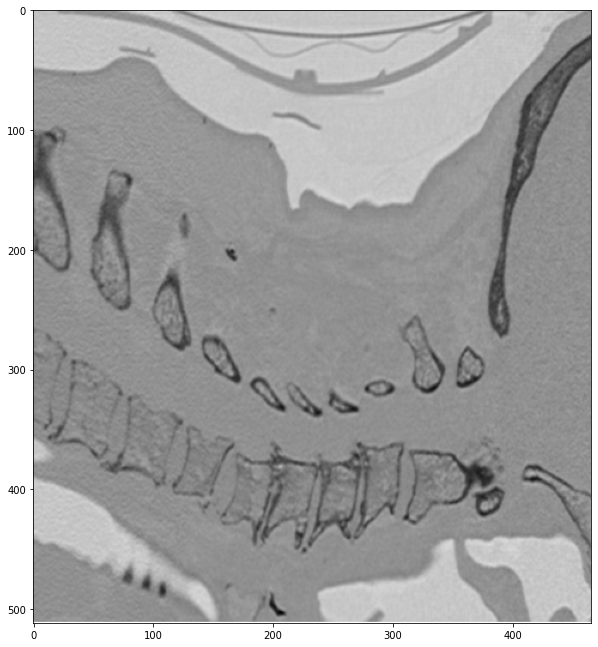

In [17]:
#We have to get the middle slice of all the images, which we can do simply by dividing the # of images by 2
middle_point = int(data_transposed.shape[2] / 2)
print(middle_point)

plt.figure(figsize=(10,15))

plt.imshow(data_transposed[middle_point], cmap='binary')
plt.imshow(data_transposed[middle_point], cmap='bone')

In [23]:
import shutil


#Lets make this into a function with the inputs being Patient_ID as string
def convert_to_sagittaral(patient_id):
    
    #Step 1: Get the filepath of the patient
    base_path = "../input/rsna-2022-cervical-spine-fracture-detection/train_images/"
    patient_path = f"{base_path}{patient_id}/"
    
    #clear all the files in the dcm_export for now, and add the new dcm files with new modality into it
    #at some point we will need to store all of them so that we have
    shutil.rmtree(export_dir)
    os.mkdir(export_dir)
    #for f in export_dir:
    #    os.remove(f)
        
    #Step 2: Add CT modality for all the images of our patient's cervical spine
    image_number = 1

    for filename in os.listdir(patient_path):
        path = patient_path + str(image_number) + ".dcm"
        dcm_example = pydicom.dcmread(path)
        dcm_example.add_new([0x0008, 0x0060], "CS", "CT")
        pydicom.filewriter.write_file(f"{export_dir}/{image_number}.dcm", dcm_example, write_like_original=True)
        image_number += 1

    print(f"Saved {image_number-1} images")
    
    #Step 3: Convert all DCM files into NFTI files
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(export_dir)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    image = sitk.PermuteAxes(image, [2, 1, 0])
    sitk.WriteImage(image, f"{patient_id}.nii.gz")
    example_path_nii = f"{patient_id}.nii.gz"
    nii_example = nib.load(example_path_nii)
    data = nii_example.get_fdata()
    data_transposed = data[:, ::-1, ::-1].transpose(2, 1, 0)
    data_transposed.shape
    
    #We have to get the middle slice of all the images, which we can do simply by dividing the # of images by 2
    middle_point = int(data_transposed.shape[2] / 2)
    print(middle_point)

    plt.figure(figsize=(10,15))
    plt.imshow(data_transposed[middle_point], cmap='bone')

Saved 685 images


ImageSeriesReader (0x55a322f43b70): Non uniform sampling or missing slices detected,  maximum nonuniformity:0.0005



342


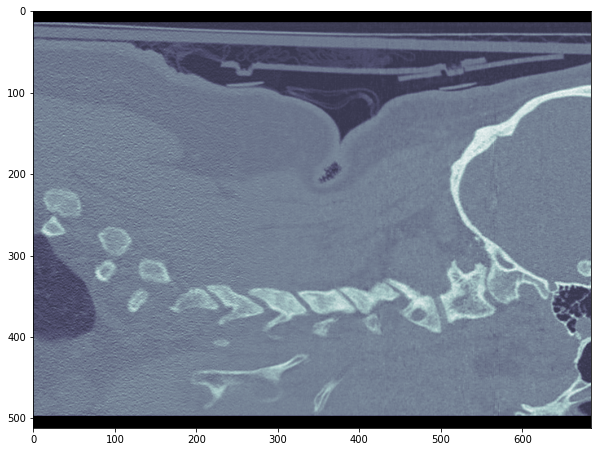

In [27]:
#testing function

convert_to_sagittaral('1.2.826.0.1.3680043.10412')